In [ ]:
# Plot style
import seaborn as sns
sns.set_style("ticks")
sns.set_palette("pastel")
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir("/content/drive/MyDrive/trajectories/aspirin")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install torch
!pip install torch-geometric
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cpu.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cpu.html
# !pip install torch-cluster -f https://data.pyg.org/whl/torch-1.10.0+cpu.html
# !pip install torch-spline-conv -f https://data.pyg.org/whl/torch-1.10.0+cpu.html

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/torch-{torch.__version__}.html
Looking in links: https://data.pyg.org/whl/torch-{torch.__version__}.html
Looking in links: https://data.pyg.org/whl/torch-{torch.__version__}.html
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-_uw21o6q
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-_uw21o6q
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 476e768593d91c1622b02440e25bbc93fc7f5294
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric
import math
import torch.nn.functional as F

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets


from torch_geometric.data import Data, DataLoader, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.utils import dense_to_sparse
from torch_geometric.nn import GATConv
import torch.optim as optim

import numpy as np

import seaborn as sns
sns.set_style("ticks")
sns.set_palette("pastel")
import matplotlib.pyplot as plt

In [ ]:
def read_xyz_multi_frame(file_path):
    """Read XYZ file with multiple frames and extract atom types and coordinates."""
    with open(file_path, 'r') as file:
        lines = file.readlines()

    frames = []
    i = 0
    while i < len(lines):
        num_atoms = int(lines[i].strip())
        comment = lines[i + 1].strip()

        atom_types = []
        coordinates = []

        for line in lines[i + 2:i + 2 + num_atoms]:
            parts = line.split()
            atom_types.append(parts[0])
            coordinates.append([float(parts[1]), float(parts[2]), float(parts[3])])

        frames.append((atom_types, np.array(coordinates)))
        i += 2 + num_atoms

    return frames

def calculate_bond_connectivities(coordinates, bond_threshold=1.6):
    """Calculate bond connectivities based on distance threshold."""
    num_atoms = coordinates.shape[0]
    bonds = []

    for i in range(num_atoms):
        for j in range(i + 1, num_atoms):
            distance = np.linalg.norm(coordinates[i] - coordinates[j])
            if distance < bond_threshold:
                bonds.append((i, j))

    return bonds

def calculate_dihedral_angle(p1, p2, p3, p4):
    """Calculate the dihedral angle between four points."""
    b1 = p2 - p1
    b2 = p3 - p2
    b3 = p4 - p3

    n1 = np.cross(b1, b2)
    n2 = np.cross(b2, b3)

    n1 /= np.linalg.norm(n1)
    n2 /= np.linalg.norm(n2)

    m1 = np.cross(n1, b2 / np.linalg.norm(b2))

    x = np.dot(n1, n2)
    y = np.dot(m1, n2)

    return np.arctan2(y, x)

def calculate_bond_dihedral_angles(atom_types, coordinates, bonds):
    """Calculate all dihedral angles for each bond."""
    num_atoms = len(atom_types)
    bond_dihedral_angles = {bond: [] for bond in bonds}

    for (i, j) in bonds:
        for k in range(num_atoms):
            if k != i and k != j:
                if (k, i) in bonds or (i, k) in bonds:
                    for l in range(num_atoms):
                        if l != i and l != j and l != k:
                            if (k, l) in bonds or (l, k) in bonds:
                                dihedral_angle = calculate_dihedral_angle(coordinates[i], coordinates[j], coordinates[k], coordinates[l])
                                bond_dihedral_angles[(i, j)].append(dihedral_angle)

    return bond_dihedral_angles

def process_xyz_frames(frames):
    """Process each frame in the XYZ file and convert to PyTorch Geometric Data objects."""
    graph_data_list = []

    # Calculate bond connectivities once using the first frame's coordinates
    _, first_coordinates = frames[0]
    bonds = calculate_bond_connectivities(first_coordinates)

    for frame_idx, (atom_types, coordinates) in enumerate(frames):
        bond_dihedral_angles = calculate_bond_dihedral_angles(atom_types, coordinates, bonds)

        # Node features: element type one-hot encoding
        elements = sorted(set(atom_types))
        element_to_index = {element: i for i, element in enumerate(elements)}

        x = torch.zeros((len(atom_types), len(elements)), dtype=torch.float)
        for i, atom in enumerate(atom_types):
            x[i, element_to_index[atom]] = 1.0

        # Positional data
        pos = torch.tensor(coordinates, dtype=torch.float)

        # Edge index and attributes
        edge_index = torch.tensor(bonds, dtype=torch.long).t().contiguous()

        # Bond lengths as edge attributes
        edge_attr = []
        for (i, j) in bonds:
            bond_length = np.linalg.norm(coordinates[i] - coordinates[j])
            edge_attr.append([bond_length])
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)

        # Store dihedral angles for each bond
        dihedral_attr = []
        max_dihedrals = max(len(angles) for angles in bond_dihedral_angles.values())

        for (i, j) in bonds:
            angles = bond_dihedral_angles[(i, j)]
            padded_angles = angles + [0.0] * (max_dihedrals - len(angles))  # Pad with zeros
            dihedral_attr.append(padded_angles)

        dihedral_attr = torch.tensor(dihedral_attr, dtype=torch.float)

        # Concatenate bond lengths and dihedral angles into edge attributes
        edge_attr = torch.cat([edge_attr, dihedral_attr], dim=1)

        graph_data = Data(x=x, pos=pos, edge_index=edge_index, edge_attr=edge_attr)
        graph_data_list.append(graph_data)

    return graph_data_list



def load_and_process_data(train_file_path, test_file_path):
    """Load and process data from XYZ files."""
    frames_train = read_xyz_multi_frame(train_file_path)
    frames_test = read_xyz_multi_frame(test_file_path)

    # Move the first 350 frames from test to train
    frames_train.extend(frames_test[:350])
    frames_test = frames_test[350:]

    # Process the frames into PyTorch Geometric Data objects
    train_data = process_xyz_frames(frames_train)
    test_data = process_xyz_frames(frames_test)

    return train_data, test_data

def print_graph_info(graph_data_list, label):
    if graph_data_list:
        graph = graph_data_list[0]
        print(f"{label} Graph:")
        print("Nodes (features):", graph.x)
        print("Positions:", graph.pos)
        print("Edges (index):", graph.edge_index)
        print("Edge Attributes:", graph.edge_attr)
    else:
        print(f"No {label} graph data available.")


train_file_path = 'aspirin_ccsd-train.xyz'
test_file_path = 'aspirin_ccsd-test.xyz'

train_data, test_data = load_and_process_data(train_file_path, test_file_path)

print(f"Processed {len(train_data)} training frames and {len(test_data)} test frames.")

# Print the graph information for the first training and testing frames
# print_graph_info(train_data, "Train")
# print_graph_info(test_data, "Test")


Processed 1350 training frames and 150 test frames.


GAT model

Epoch [1/10], Loss: 2.3144
Epoch [2/10], Loss: 2.3015
Epoch [3/10], Loss: 2.3010
Epoch [4/10], Loss: 2.3008
Epoch [5/10], Loss: 2.3006
Epoch [6/10], Loss: 2.3074
Epoch [7/10], Loss: 2.3004
Epoch [8/10], Loss: 2.3003
Epoch [9/10], Loss: 2.3002
Epoch [10/10], Loss: 2.3001
Average Test RMSD: 1.5165


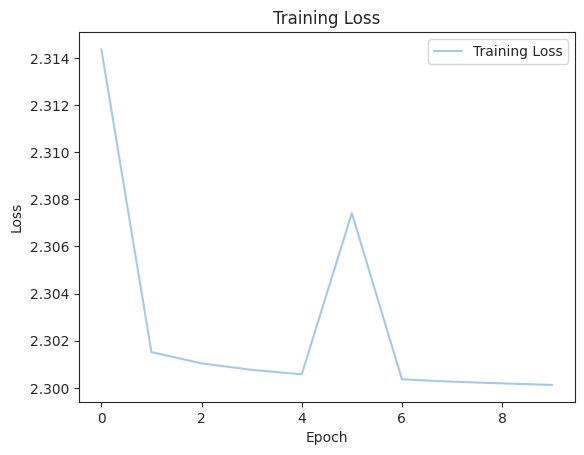

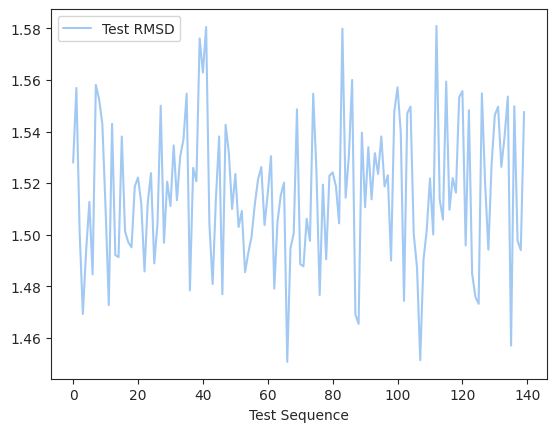

Comparison for test sample 0:
Output shape: torch.Size([21, 3])


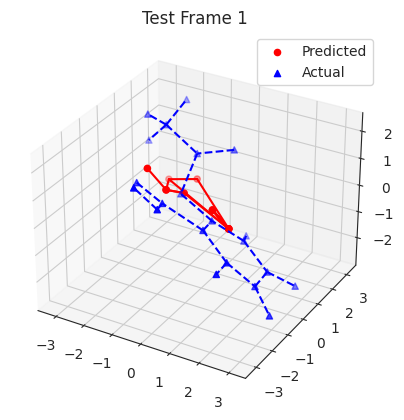

Comparison for test sample 1:
Output shape: torch.Size([21, 3])


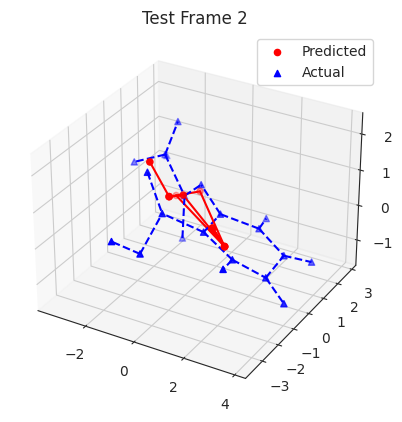

Comparison for test sample 2:
Output shape: torch.Size([21, 3])


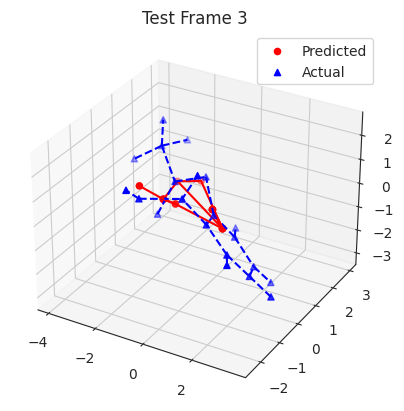

In [ ]:
class MolecularTrajectoryDataset(torch.utils.data.Dataset):
    def __init__(self, graph_data_list, seq_length):
        self.graph_data_list = graph_data_list
        self.seq_length = seq_length

    def __len__(self):
        return len(self.graph_data_list) - self.seq_length

    def __getitem__(self, idx):
        graphs = self.graph_data_list[idx:idx + self.seq_length]
        next_graph = self.graph_data_list[idx + self.seq_length].pos
        return graphs, next_graph

def compute_rmsd(predicted, actual):
    return np.sqrt(((predicted - actual) ** 2).mean())

seq_length = 10
train_dataset = MolecularTrajectoryDataset(train_data, seq_length)
test_dataset = MolecularTrajectoryDataset(test_data, seq_length)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Define GAT Layer
class GATLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GATLayer, self).__init__()
        self.gat = GATConv(in_channels, out_channels, heads=8, concat=True)

    def forward(self, x, edge_index, edge_attr):
        # print("Inside GATLayer forward pass:")
        # print(f"x shape: {x.shape}")
        # print(f"edge_index shape: {edge_index.shape}")
        # print(f"edge_attr shape: {edge_attr.shape}")

        x = self.gat(x, edge_index, edge_attr=edge_attr)
        x = F.elu(x)

        # print(f"x shape after GAT: {x.shape}")
        return x

# Define Temporal Layer
class TemporalLayer(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(TemporalLayer, self).__init__()
        self.lstm = nn.LSTM(in_channels, hidden_channels, batch_first=True)

    def forward(self, x):
        # print("Inside TemporalLayer forward pass:")
        # print(f"x shape before LSTM: {x.shape}")

        x, _ = self.lstm(x)

        # print(f"x shape after LSTM: {x.shape}")
        return x

# Define Prediction Model
class MotionPredictionModel(nn.Module):
    def __init__(self, node_features, hidden_channels, output_dim):
        super(MotionPredictionModel, self).__init__()
        self.gat_layer = GATLayer(node_features, hidden_channels)
        self.temporal_layer = TemporalLayer(hidden_channels * 8, hidden_channels)
        self.fc = nn.Linear(hidden_channels, output_dim)

    def forward(self, graphs, batch_size, seq_length):
        gat_out = []
        for t in range(seq_length):
            graph = graphs[t]
            x_t = graph.x  # Shape: (num_nodes, num_features)
            edge_index_t = graph.edge_index
            edge_attr_t = graph.edge_attr

            # print(f"Time step {t} forward pass:")
            # print(f"x_t shape: {x_t.shape}")
            # print(f"edge_index_t shape: {edge_index_t.shape}")
            # print(f"edge_attr_t shape: {edge_attr_t.shape}")

            x_t = x_t.view(-1, x_t.shape[-1])
            gat_out_t = self.gat_layer(x_t, edge_index_t, edge_attr_t)
            gat_out.append(gat_out_t)

        gat_out = torch.stack(gat_out, dim=0)
        # print(f"gat_out shape after stack: {gat_out.shape}")

        gat_out = gat_out.permute(1, 0, 2)
        # print(f"gat_out shape after permute: {gat_out.shape}")

        temporal_out = self.temporal_layer(gat_out)
        # print(f"temporal_out shape: {temporal_out.shape}")

        temporal_out = temporal_out.permute(1, 0, 2)
        temporal_out = temporal_out[-1]
        # print(f"temporal_out shape after select last: {temporal_out.shape}")

        predictions = self.fc(temporal_out)  # Shape: (num_nodes, output_dim)
        # print(f"predictions shape: {predictions.shape}")

        return predictions

node_features = train_data[0].x.size(1)
hidden_channels = 64
output_dim = 3

model = MotionPredictionModel(node_features, hidden_channels, output_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

num_epochs = 10
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for graphs, target in train_loader:
        optimizer.zero_grad()
        batch_size = 1
        seq_length = len(graphs)

        # print(f"Training epoch {epoch}, graph batch:")
        # print(f"graphs length: {len(graphs)}")
        # print(f"target shape: {target.shape}")

        output = model(graphs, batch_size, seq_length)
        # print(f"Output shape: {output.shape}")

        loss = criterion(output, target.squeeze())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")

model.eval()
test_rmsds = []
with torch.no_grad():
    for graphs, target in test_loader:
        batch_size = 1
        seq_length = len(graphs)

        # print(f"Testing graph batch:")
        # print(f"graphs length: {len(graphs)}")
        # print(f"target shape: {target.shape}")

        output = model(graphs, batch_size, seq_length)
        # print(f"Output shape: {output.shape}")

        test_rmsd = compute_rmsd(output.numpy(), target.squeeze().numpy())
        test_rmsds.append(test_rmsd)

print(f"Average Test RMSD: {np.mean(test_rmsds):.4f}")

plt.figure()
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(len(test_rmsds)), test_rmsds, label='Test RMSD')
plt.xlabel('Test Sequence')
plt.ylabel=('RMSD')
plt.title=('Test RMSD')
plt.legend()
plt.show()

model.eval()
with torch.no_grad():
    for i, (graphs, target) in enumerate(test_loader):
        if i >= 3:
            break
        batch_size = 1
        seq_length = len(graphs)

        print(f"Comparison for test sample {i}:")

        output = model(graphs, batch_size, seq_length)
        print(f"Output shape: {output.shape}")

        predicted = output.numpy()
        actual = target.squeeze().numpy()
        edge_index = graphs[-1].edge_index.numpy()

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(predicted[:, 0], predicted[:, 1], predicted[:, 2], c='r', marker='o', label='Predicted')
        ax.scatter(actual[:, 0], actual[:, 1], actual[:, 2], c='b', marker='^', label='Actual')

        for j in range(edge_index.shape[1]):
            start, end = edge_index[:, j]
            ax.plot([predicted[start, 0], predicted[end, 0]],
                    [predicted[start, 1], predicted[end, 1]],
                    [predicted[start, 2], predicted[end, 2]], 'r-')
            ax.plot([actual[start, 0], actual[end, 0]],
                    [actual[start, 1], actual[end, 1]],
                    [actual[start, 2], actual[end, 2]], 'b--')

        ax.set_title(f'Test Frame {i+1}')
        ax.legend()
        plt.show()